In [17]:
%pip install optuna  

Note: you may need to restart the kernel to use updated packages.


✅ Models imported
✅ Evaluation metrics imported
✅ Optimization modules imported
✅ Bayesian tuner imported
🚛 DYNAMIC TRIP RESCHEDULING SYSTEM

📊 LOADING DATA
----------------------------------------
✅ Loaded 14,817 trips
✅ Loaded 1,504 routes
✅ Date range: 2018-09-12 to 2018-10-04

🔧 INITIALIZING DRIVER STATES
----------------------------------------


[I 2025-08-06 08:39:38,516] A new study created in memory with name: trip_rescheduling_20250806_083938


✅ Initialized 1504 driver states
⚠️  Could not calculate system utilization: 'total_capacity_used_hours'
📊 Drivers initialized: 1504

📍 LOADING DISTANCE MATRIX
----------------------------------------
✅ Loaded distance matrix: (1319, 1319)
✅ Number of locations: 1319
📊 Average travel time: 2841.4 minutes
📊 Max travel time: 5448.7 minutes

🔧 FIXING LOCATION MAPPING
----------------------------------------
📦 Current trip location format:
  Sample source_center values:
    'IND421302AAG'
    'IND560048AAB'
    'IND853204AAA'
    'IND713130AAA'
    'IND742101AAC'

  Sample destination_center values:
    'IND401104AAA'
    'IND421302AAG'
    'IND562132AAA'
    'IND851204AAA'
    'IND742101AAC'

📊 Checking for center_id columns in trips:
  Columns in trips: ['route_schedule_uuid', 'trip_uuid', 'segment_actual_time', 'segment_osrm_time', 'segment_osrm_distance', 'actual_time', 'osrm_time', 'osrm_distance', 'cutoff_factor', 'start_scan_to_end_scan', 'od_start_time', 'od_end_time', 'source_cent

[I 2025-08-06 08:39:38,569] Trial 0 finished with value: 0.1568 and parameters: {'cost_weight': 0.25472441754532027, 'service_weight': 0.21109657134006407, 'compliance_weight': 0.1928810335990839, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:38,617] Trial 1 finished with value: 0.1568 and parameters: {'cost_weight': 0.6136292317900909, 'service_weight': 0.56961660501891, 'compliance_weight': 0.19122170307380762, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:38,698] Trial 2 finished with value: 0.1568 and parameters: {'cost_weight': 0.3164749899084427, 'service_weight': 0.1287631650945932, 'compliance_weight': 0.41545449135302837, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1568.



Solver Statistics:
  Status: OPTIMAL
  Objective: 232020.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 9
  • Outsourced: 6
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 6
  • Direct assignments: 9

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 60.0%
  • Successfully Reassigned: 9/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,180.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,000.00

📋 SLA COMPLIANCE
  • On-Time Rate: 60.0%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Score: 100.0%

🎯 MULTI-OBJECTIVE SCORES
  • Cost Score: 0.212 (lower is better)
  • Service Quality: 0.760 (higher is better)
  • Combined Objective: 0.157 (lower is better)

Trial 1:
  Parameters: {'cost_weight': 0.38670659698

[I 2025-08-06 08:39:38,780] Trial 3 finished with value: 0.1568 and parameters: {'cost_weight': 0.48312838334471986, 'service_weight': 0.4228582721691626, 'compliance_weight': 0.17683018451276913, 'max_cascade_depth': 3}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:38,870] Trial 4 finished with value: 0.1568 and parameters: {'cost_weight': 0.23168604062078013, 'service_weight': 0.2907765007427765, 'compliance_weight': 0.26248384643324274, 'max_cascade_depth': 3}. Best is trial 0 with value: 0.1568.



Solver Statistics:
  Status: OPTIMAL
  Objective: 267702.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 9
  • Outsourced: 6
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 6
  • Direct assignments: 9

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 60.0%
  • Successfully Reassigned: 9/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,180.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,000.00

📋 SLA COMPLIANCE
  • On-Time Rate: 60.0%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Score: 100.0%

🎯 MULTI-OBJECTIVE SCORES
  • Cost Score: 0.212 (lower is better)
  • Service Quality: 0.760 (higher is better)
  • Combined Objective: 0.157 (lower is better)

Trial 4:
  Parameters: {'cost_weight': 0.44617738243

[I 2025-08-06 08:39:38,964] Trial 5 finished with value: 0.1568 and parameters: {'cost_weight': 0.5972095548199718, 'service_weight': 0.5678456515706259, 'compliance_weight': 0.2938546618754936, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:39,011] Trial 6 finished with value: 0.1568 and parameters: {'cost_weight': 0.2060045439700388, 'service_weight': 0.20334043824675477, 'compliance_weight': 0.23819331584549217, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:39,089] Trial 7 finished with value: 0.1568 and parameters: {'cost_weight': 0.3906643351998733, 'service_weight': 0.4516451149715216, 'compliance_weight': 0.2792332226503943, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1568.



🚀 Starting optimization for 15 disrupted trips

📋 Generating candidates...
  Trip trip-153701473441299363: 1 candidates
  Trip trip-153856463279004477: 20 candidates
  Trip trip-153756713929871939: 20 candidates
  Trip trip-153774227248337690: 20 candidates
  Trip trip-153850290910260618: 1 candidates
  Trip trip-153751473600616231: 20 candidates
  Trip trip-153697185494123780: 20 candidates
  Trip trip-153861091843037040: 20 candidates
  Trip trip-153714485250886508: 20 candidates
  Trip trip-153671328307356992: 1 candidates
  Trip trip-153791691027779131: 1 candidates
  Trip trip-153713543941926070: 20 candidates
  Trip trip-153689211548387787: 20 candidates
  Trip trip-153758280646960295: 1 candidates
  Trip trip-153783465306198961: 1 candidates
Total candidates generated: 186

🧮 Solving with CP-SAT...
Created 186 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 190878.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Rea

[I 2025-08-06 08:39:39,167] Trial 8 finished with value: 0.1568 and parameters: {'cost_weight': 0.16223659815932412, 'service_weight': 0.3764750560673432, 'compliance_weight': 0.5137253821651203, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:39,251] Trial 9 finished with value: 0.1568 and parameters: {'cost_weight': 0.24466522323024126, 'service_weight': 0.5771136085131479, 'compliance_weight': 0.17644774502889152, 'max_cascade_depth': 3}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:39,296] Trial 10 finished with value: 0.1568 and parameters: {'cost_weight': 0.4596144794253322, 'service_weight': 0.2599508629404972, 'compliance_weight': 0.11887890106255194, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:39,349] Trial 11 finished with value: 0.1568 and parameters: {'cost_weight': 0.6405929316148123, 'service_weight': 0.10567484067737204, 'compliance_weight': 0.3738712771484901, 'max_cascade_depth': 1}. Best 


Solver Statistics:
  Status: OPTIMAL
  Objective: 92490.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 9
  • Outsourced: 6
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 6
  • Direct assignments: 9

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 60.0%
  • Successfully Reassigned: 9/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,180.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,000.00

📋 SLA COMPLIANCE
  • On-Time Rate: 60.0%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Score: 100.0%

🎯 MULTI-OBJECTIVE SCORES
  • Cost Score: 0.212 (lower is better)
  • Service Quality: 0.760 (higher is better)
  • Combined Objective: 0.157 (lower is better)

Trial 9:
  Parameters: {'cost_weight': 0.154153258151

[I 2025-08-06 08:39:39,465] Trial 12 finished with value: 0.1568 and parameters: {'cost_weight': 0.5265577368526656, 'service_weight': 0.47430072168980225, 'compliance_weight': 0.1386575441727571, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:39,501] Trial 13 finished with value: 0.1568 and parameters: {'cost_weight': 0.10014905701977211, 'service_weight': 0.3188849714235249, 'compliance_weight': 0.2074209290285825, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:39,600] Trial 14 finished with value: 0.1568 and parameters: {'cost_weight': 0.3503174349800606, 'service_weight': 0.20150457195204907, 'compliance_weight': 0.5997449763296739, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1568.



🚀 Starting optimization for 15 disrupted trips

📋 Generating candidates...
  Trip trip-153701473441299363: 1 candidates
  Trip trip-153856463279004477: 20 candidates
  Trip trip-153756713929871939: 20 candidates
  Trip trip-153774227248337690: 20 candidates
  Trip trip-153850290910260618: 1 candidates
  Trip trip-153751473600616231: 20 candidates
  Trip trip-153697185494123780: 20 candidates
  Trip trip-153861091843037040: 20 candidates
  Trip trip-153714485250886508: 20 candidates
  Trip trip-153671328307356992: 1 candidates
  Trip trip-153791691027779131: 1 candidates
  Trip trip-153713543941926070: 20 candidates
  Trip trip-153689211548387787: 20 candidates
  Trip trip-153758280646960295: 1 candidates
  Trip trip-153783465306198961: 1 candidates
Total candidates generated: 186

🧮 Solving with CP-SAT...
Created 186 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 277248.0
  Time: 0.01s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Rea

[I 2025-08-06 08:39:39,683] Trial 15 finished with value: 0.1568 and parameters: {'cost_weight': 0.6809518677485683, 'service_weight': 0.4909255750840703, 'compliance_weight': 0.3247774026327843, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:39,731] Trial 16 finished with value: 0.1568 and parameters: {'cost_weight': 0.30648694933449017, 'service_weight': 0.38058506138711157, 'compliance_weight': 0.1001552420862557, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:39,782] Trial 17 finished with value: 0.1568 and parameters: {'cost_weight': 0.5744469239881675, 'service_weight': 0.22124659019799126, 'compliance_weight': 0.41281864462038853, 'max_cascade_depth': 1}. Best is trial 0 with value: 0.1568.
[I 2025-08-06 08:39:39,833] Trial 18 finished with value: 0.1568 and parameters: {'cost_weight': 0.41788890229175385, 'service_weight': 0.5213203691641408, 'compliance_weight': 0.203314289337303, 'max_cascade_depth': 1}. Best

  Trip trip-153689211548387787: 20 candidates
  Trip trip-153758280646960295: 1 candidates
  Trip trip-153783465306198961: 1 candidates
Total candidates generated: 186

🧮 Solving with CP-SAT...
Created 186 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 272988.0
  Time: 0.00s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 9
  • Outsourced: 6
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 6
  • Direct assignments: 9

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 60.0%
  • Successfully Reassigned: 9/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,180.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,000.00

📋 SLA COMPLIANCE
  • On-Time Rate: 60.0%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Sc

[I 2025-08-06 08:39:39,916] Trial 19 finished with value: 0.1568 and parameters: {'cost_weight': 0.27554236563373435, 'service_weight': 0.1592218873029832, 'compliance_weight': 0.35076206308888164, 'max_cascade_depth': 2}. Best is trial 0 with value: 0.1568.


  Trip trip-153689211548387787: 20 candidates
  Trip trip-153758280646960295: 1 candidates
  Trip trip-153783465306198961: 1 candidates
Total candidates generated: 186

🧮 Solving with CP-SAT...
Created 186 decision variables

Solver Statistics:
  Status: OPTIMAL
  Objective: 210462.0
  Time: 0.00s
  Branches: 0
  Conflicts: 0

SOLUTION SUMMARY

📊 Assignment Results:
  • Reassigned: 9
  • Outsourced: 6
  • Total: 15

🔄 Cascade Analysis:
  • 0-driver cascades: 6
  • Direct assignments: 9

💰 Cost Components:
  • Total deadhead: 0 minutes
  • Total delay: 0 minutes
  • Emergency rests used: 0

OPTIMIZATION METRICS SUMMARY

📊 OPERATIONAL PERFORMANCE
  • Feasibility Rate: 60.0%
  • Successfully Reassigned: 9/15
  • Optimization Time: 0.00s

💰 COST METRICS
  • Total Cost: $3,180.00
  • Deadhead Cost: $0.00
  • Outsourcing Cost: $3,000.00

📋 SLA COMPLIANCE
  • On-Time Rate: 60.0%
  • Average Delay: 0.0 min
  • SLA Target Met: ❌

⚖️ REGULATORY COMPLIANCE
  • Fully Compliant: ✅
  • Compliance Sc

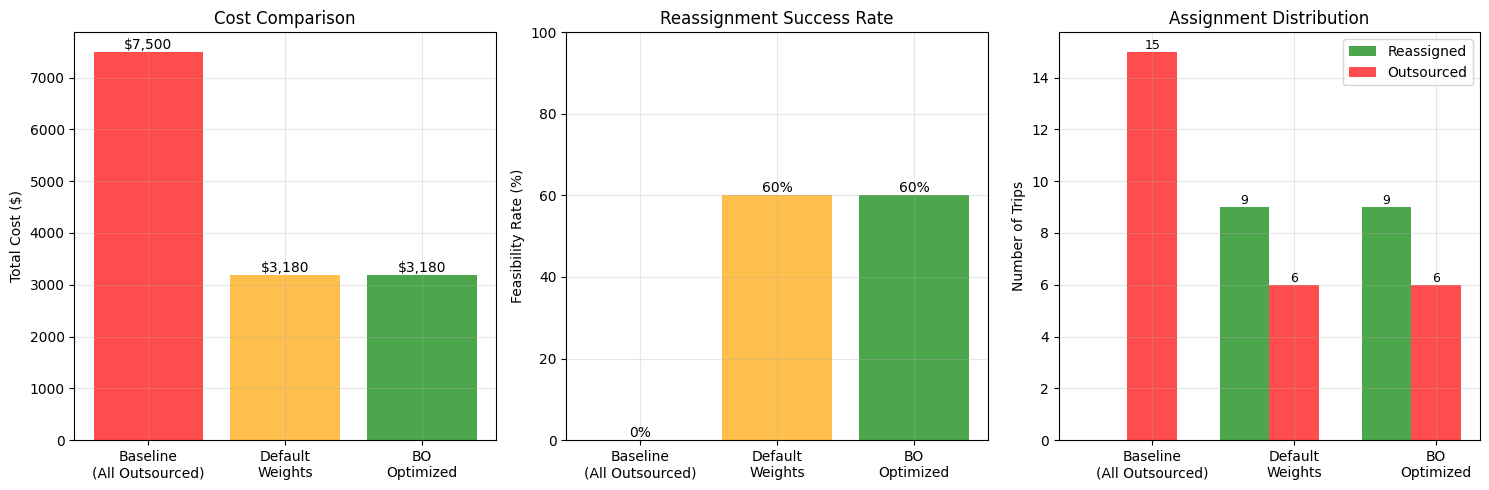


🎯 KEY INSIGHTS
✅ Cost Reduction: $4,320.00 (57.6%)
✅ Trips Reassigned: 9 (60%)
✅ Avoided Outsourcing: 9 trips

📊 Bayesian Optimization Performance:
  • Trials Run: 20
  • Best Combined Objective: 0.1568
  • Average Solve Time: 0.01s

✅ OPTIMIZATION COMPLETE


In [ ]:
"""
DYNAMIC TRIP RESCHEDULING WITH BAYESIAN OPTIMIZATION
====================================================
Multi-driver cascading reassignment with CP-SAT and Bayesian Optimization
"""

# ============================================================================
# SETUP
# ============================================================================

import sys
import os
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import our modules with error handling
try:
    from models.driver_state import DriverState, DailyAssignment
    print("✅ Models imported")
except ImportError as e:
    print(f"❌ Error importing models: {e}")
    raise

try:
    from evaluation_metrics import OptimizationMetrics, MetricsCalculator
    print("✅ Evaluation metrics imported")
except ImportError as e:
    print(f"❌ Error importing evaluation_metrics: {e}")
    raise

try:
    from opt.candidate_gen_v2 import CandidateGeneratorV2
    from opt.cpsat_model_v2 import CPSATOptimizer
    print("✅ Optimization modules imported")
except ImportError as e:
    print(f"❌ Error importing optimization modules: {e}")
    raise

try:
    from opt.bayesian_tuner import BayesianOptimizationTuner
    print("✅ Bayesian tuner imported")
except ImportError as e:
    print(f"⚠️  Warning: Could not import Bayesian tuner: {e}")
    print("   Will use fallback random search")
    BayesianOptimizationTuner = None

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("🚛 DYNAMIC TRIP RESCHEDULING SYSTEM")
print("=" * 50)

# ============================================================================
# 1. LOAD DATA
# ============================================================================

print("\n📊 LOADING DATA")
print("-" * 40)

df_trips = pd.read_csv("../data/processed/trips.csv", parse_dates=['od_start_time', 'od_end_time'])
df_routes = pd.read_csv("../data/processed/routes.csv", parse_dates=['route_start_time', 'route_end_time'])

print(f"✅ Loaded {len(df_trips):,} trips")
print(f"✅ Loaded {len(df_routes):,} routes")
print(f"✅ Date range: {df_trips['od_start_time'].min().date()} to {df_trips['od_start_time'].max().date()}")

# ============================================================================
# 2. INITIALIZE DRIVER STATES
# ============================================================================

print("\n🔧 INITIALIZING DRIVER STATES")
print("-" * 40)

driver_states = {}

# Create DriverState for each unique driver
for _, route in df_routes.iterrows():
    driver_id = route['route_schedule_uuid']
    
    # Get all trips for this driver
    driver_trips = df_trips[df_trips['route_schedule_uuid'] == driver_id].copy()
    
    if len(driver_trips) > 0:
        driver_state = DriverState(driver_id=driver_id, route_id=driver_id)
        
        # Add assignments
        for _, trip in driver_trips.iterrows():
            date_str = trip['od_start_time'].strftime('%Y-%m-%d')
            
            assignment = DailyAssignment(
                trip_id=trip['trip_uuid'],
                start_time=trip['od_start_time'],
                end_time=trip['od_end_time'],
                duration_minutes=int(trip['trip_duration_minutes']),
                start_location=str(trip['source_center']),
                end_location=str(trip['destination_center'])
            )
            
            driver_state.add_assignment(date_str, assignment)
        
        driver_states[driver_id] = driver_state

print(f"✅ Initialized {len(driver_states)} driver states")

# Show driver utilization (with error handling for different DriverState implementations)
try:
    # Try to get utilization summary
    sample_summary = list(driver_states.values())[0].get_utilization_summary() if driver_states else {}
    
    # Check what keys are available and use them
    if 'total_capacity_used_hours' in sample_summary:
        total_capacity_used = sum(d.get_utilization_summary()['total_capacity_used_hours'] 
                                 for d in driver_states.values())
        total_capacity_available = sum(d.get_utilization_summary()['total_days'] * 13 
                                      for d in driver_states.values())
    else:
        # Fallback: calculate from assignments directly
        total_capacity_used = 0
        total_days = 0
        for driver in driver_states.values():
            summary = driver.get_utilization_summary()
            # Use whatever keys are available
            if 'total_hours' in summary:
                total_capacity_used += summary['total_hours']
            elif 'total_minutes' in summary:
                total_capacity_used += summary['total_minutes'] / 60
            
            if 'total_days' in summary:
                total_days += summary['total_days']
            elif 'days_worked' in summary:
                total_days += summary['days_worked']
        
        total_capacity_available = total_days * 13  # 13 hour daily limit
    
    system_utilization = total_capacity_used / total_capacity_available if total_capacity_available > 0 else 0
    
    print(f"📊 System utilization: {system_utilization:.1%}")
    print(f"📊 Available capacity: {total_capacity_available - total_capacity_used:,.0f} hours")
    
except Exception as e:
    print(f"⚠️  Could not calculate system utilization: {e}")
    print(f"📊 Drivers initialized: {len(driver_states)}")

# ============================================================================
# 3. LOAD DISTANCE MATRIX
# ============================================================================

print("\n📍 LOADING DISTANCE MATRIX")
print("-" * 40)

try:
    # Load the distance matrix
    dist_data = np.load("../data/dist_matrix.npz", allow_pickle=True)
    distance_matrix = dist_data['time']  # Travel time matrix
    location_ids = dist_data['ids']  # Location IDs
    
    # Create location mapping from the IDs in the file
    location_to_index = {loc: i for i, loc in enumerate(location_ids)}
    
    print(f"✅ Loaded distance matrix: {distance_matrix.shape}")
    print(f"✅ Number of locations: {len(location_ids)}")
    print(f"📊 Average travel time: {np.mean(distance_matrix[distance_matrix > 0]):.1f} minutes")
    print(f"📊 Max travel time: {np.max(distance_matrix):.1f} minutes")
    
except FileNotFoundError:
    print("⚠️  Distance matrix not found, using default travel times")
    distance_matrix = None
    location_to_index = None

# ============================================================================
# FIX LOCATION MAPPING - USE CENTER_IDs CONSISTENTLY
# ============================================================================

print("\n🔧 FIXING LOCATION MAPPING")
print("-" * 40)

# 1. First, let's see what format the trips are using
print("📦 Current trip location format:")
print(f"  Sample source_center values:")
for loc in df_trips['source_center'].unique()[:5]:
    print(f"    '{loc}'")

print(f"\n  Sample destination_center values:")
for loc in df_trips['destination_center'].unique()[:5]:
    print(f"    '{loc}'")

# 2. Check if trips already have center_id columns
print(f"\n📊 Checking for center_id columns in trips:")
print(f"  Columns in trips: {df_trips.columns.tolist()}")

if 'source_center_id' in df_trips.columns and 'destination_center_id' in df_trips.columns:
    print("  ✅ Found source_center_id and destination_center_id columns!")
    
    # Use these for the disrupted trips
    print("\n🔄 Updating disrupted trips to use center_ids...")
    
    # Update the disrupted_trips list to use center_ids
    disrupted_trips_fixed = []
    for _, trip in disrupted_trips_df.iterrows():
        disrupted_trips_fixed.append({
            'id': trip['trip_uuid'],
            'start_time': trip['od_start_time'],
            'end_time': trip['od_end_time'],
            'duration_minutes': trip['trip_duration_minutes'],
            'start_location': trip['source_center_id'] if 'source_center_id' in trip else trip['source_center'],
            'end_location': trip['destination_center_id'] if 'destination_center_id' in trip else trip['destination_center']
        })
    
    disrupted_trips = disrupted_trips_fixed
    print(f"  ✅ Updated {len(disrupted_trips)} disrupted trips to use center_ids")
    
    # Show sample
    if disrupted_trips:
        print(f"\n  Sample updated trip:")
        print(f"    Start location: {disrupted_trips[0]['start_location']}")
        print(f"    End location: {disrupted_trips[0]['end_location']}")

elif 'source_center' in df_trips.columns:
    # Need to check if these are already center_ids or need mapping
    sample_val = df_trips['source_center'].iloc[0]
    
    if sample_val.startswith('IND'):
        print("  ✅ Trips already using center_id format!")
    else:
        print("  ⚠️ Trips using different format, need to load mapping")
        
        # Try to load a mapping file or create one from center_coordinates
        try:
            center_coords = pd.read_csv("../data/processed/center_coordinates.csv")
            
            # Check if there's a name column we can map from
            if 'center_name' in center_coords.columns:
                print("\n  📍 Creating mapping from center_name to center_id...")
                name_to_id = dict(zip(center_coords['center_name'], center_coords['center_id']))
                
                # Apply mapping to trips
                df_trips['source_center_id'] = df_trips['source_center'].map(name_to_id)
                df_trips['destination_center_id'] = df_trips['destination_center'].map(name_to_id)
                
                # Check how many mapped successfully
                mapped_source = df_trips['source_center_id'].notna().sum()
                mapped_dest = df_trips['destination_center_id'].notna().sum()
                
                print(f"  Mapped {mapped_source}/{len(df_trips)} source centers")
                print(f"  Mapped {mapped_dest}/{len(df_trips)} destination centers")
                
                if mapped_source < len(df_trips):
                    unmapped = df_trips[df_trips['source_center_id'].isna()]['source_center'].unique()[:5]
                    print(f"\n  ⚠️ Unmapped source centers (samples):")
                    for u in unmapped:
                        print(f"    '{u}'")
            else:
                print("  ⚠️ No center_name column found for mapping")
                
        except Exception as e:
            print(f"  ❌ Error creating mapping: {e}")

# 3. Now recreate the CPSATOptimizer with the correct mapping
print("\n🔄 Reinitializing optimizer with correct location mapping...")

# The location_to_index should use the center_ids from the distance matrix
location_to_index_fixed = {str(loc): i for i, loc in enumerate(location_ids)}

# Show sample of the fixed mapping
print(f"\n📍 Fixed location mapping (sample):")
for loc, idx in list(location_to_index_fixed.items())[:5]:
    print(f"  '{loc}' -> index {idx}")

# Reinitialize the optimizer
cpsat_optimizer = CPSATOptimizer(
    driver_states,
    distance_matrix=distance_matrix,
    location_to_index=location_to_index_fixed
)

print(f"\n✅ Optimizer reinitialized with fixed location mapping")
print(f"  Distance matrix shape: {distance_matrix.shape}")
print(f"  Number of locations in mapping: {len(location_to_index_fixed)}")

# 4. Test if deadhead calculation works now
print("\n🧪 Testing deadhead calculation with fixed mapping...")
if len(location_ids) >= 2:
    loc1, loc2 = str(location_ids[0]), str(location_ids[1])
    test_time = cpsat_optimizer.candidate_generator._calculate_travel_time(loc1, loc2)
    expected_time = distance_matrix[0, 1]
    print(f"  From: {loc1}")
    print(f"  To: {loc2}")
    print(f"  Calculated: {test_time:.1f} minutes")
    print(f"  Expected: {expected_time:.1f} minutes")
    print(f"  ✅ Match: {abs(test_time - expected_time) < 0.01}")

print("\n" + "="*40)

# ============================================================================
# 4. CREATE DISRUPTION SCENARIO
# ============================================================================

print("\n🔥 CREATING DISRUPTION SCENARIO")
print("-" * 40)

# Sample trips to disrupt
np.random.seed(42)  # For reproducibility
n_disruptions = 15
disrupted_trips_df = df_trips.sample(n=n_disruptions)

# Convert to format needed by optimizer
disrupted_trips = []
for _, trip in disrupted_trips_df.iterrows():
    disrupted_trips.append({
        'id': trip['trip_uuid'],
        'start_time': trip['od_start_time'],
        'end_time': trip['od_end_time'],
        'duration_minutes': trip['trip_duration_minutes'],
        'start_location': trip['source_center'],
        'end_location': trip['destination_center']
    })

print(f"✅ Created {len(disrupted_trips)} disrupted trips")
print(f"📊 Total duration: {sum(t['duration_minutes'] for t in disrupted_trips):,.0f} minutes")
print(f"📊 Average duration: {np.mean([t['duration_minutes'] for t in disrupted_trips]):.0f} minutes")

# ============================================================================
# 5. ESTABLISH BASELINE (No Optimization)
# ============================================================================

print("\n📏 BASELINE PERFORMANCE (All Outsourced)")
print("-" * 40)

# Calculate baseline metrics (all trips outsourced)
baseline_metrics = OptimizationMetrics()
baseline_metrics.operational.total_disrupted_trips = len(disrupted_trips)
baseline_metrics.operational.outsourced = len(disrupted_trips)
baseline_metrics.operational.feasibility_rate = 0.0

# Baseline costs (assume $500 per outsourced trip)
outsource_cost_per_trip = 500
baseline_metrics.cost.outsourcing_count = len(disrupted_trips)
baseline_metrics.cost.outsourcing_cost = len(disrupted_trips) * outsource_cost_per_trip
baseline_metrics.cost.total_cost = baseline_metrics.cost.outsourcing_cost

# Baseline SLA (assume outsourcing maintains service but at high cost)
baseline_metrics.sla.total_trips = len(disrupted_trips)
baseline_metrics.sla.on_time_deliveries = len(disrupted_trips)
baseline_metrics.sla.on_time_rate = 1.0

print(f"❌ Feasibility Rate: {baseline_metrics.operational.feasibility_rate:.0%}")
print(f"💰 Total Cost: ${baseline_metrics.cost.total_cost:,.2f}")
print(f"📦 Outsourced Trips: {baseline_metrics.operational.outsourced}/{len(disrupted_trips)}")
print(f"⏱️ On-Time Rate: {baseline_metrics.sla.on_time_rate:.0%}")

# ============================================================================
# 6. RUN CP-SAT OPTIMIZATION (Default Weights)
# ============================================================================

print("\n🧮 RUNNING CP-SAT OPTIMIZATION")
print("-" * 40)

# Initialize optimizer WITH distance matrix
cpsat_optimizer = CPSATOptimizer(
    driver_states,
    distance_matrix=distance_matrix,
    location_to_index=location_to_index
)

# Optionally adjust deadhead limits for more flexibility
# cpsat_optimizer.candidate_generator.max_deadhead_minutes = 180  # 3 hours instead of default 2 hours

# Run with default weights
print("Using default weights: cost=0.4, service=0.3, compliance=0.3")
solution_default = cpsat_optimizer.optimize(
    disrupted_trips,
    objective_weights={
        'cost_weight': 0.4,
        'service_weight': 0.3,
        'compliance_weight': 0.3
    },
    include_cascades=True,
    max_candidates_per_trip=20
)

# Show improvement over baseline
if solution_default.metrics:
    print(f"\n📈 IMPROVEMENT OVER BASELINE:")
    print(f"  Feasibility: {baseline_metrics.operational.feasibility_rate:.0%} → "
          f"{solution_default.metrics.operational.feasibility_rate:.0%}")
    print(f"  Total Cost: ${baseline_metrics.cost.total_cost:,.2f} → "
          f"${solution_default.metrics.cost.total_cost:,.2f}")
    print(f"  Cost Reduction: ${baseline_metrics.cost.total_cost - solution_default.metrics.cost.total_cost:,.2f} "
          f"({(1 - solution_default.metrics.cost.total_cost/baseline_metrics.cost.total_cost)*100:.1f}%)")
    

# ============================================================================
# DEBUG: DEADHEAD CALCULATION
# ============================================================================

print("\n🔍 DEBUGGING DEADHEAD CALCULATION")
print("-" * 40)

# 1. Check if location names match
trip_locations = set(df_trips['source_center'].unique()) | set(df_trips['destination_center'].unique())
matrix_locations = set(location_ids)

print(f"\n📍 Location Analysis:")
print(f"  • Locations in trips data: {len(trip_locations)}")
print(f"  • Locations in distance matrix: {len(matrix_locations)}")
print(f"  • Locations in common: {len(trip_locations & matrix_locations)}")
print(f"  • Missing from matrix: {len(trip_locations - matrix_locations)}")

# Show sample locations from each
print(f"\n📍 Sample trip locations:")
for loc in list(trip_locations)[:5]:
    print(f"    '{loc}'")

print(f"\n📍 Sample matrix locations:")
for loc in list(matrix_locations)[:5]:
    print(f"    '{loc}'")

# 2. Test the distance calculation directly
if len(trip_locations & matrix_locations) > 1:
    common_locs = list(trip_locations & matrix_locations)
    loc1, loc2 = common_locs[0], common_locs[1]
    idx1 = location_to_index[loc1]
    idx2 = location_to_index[loc2]
    travel_time = distance_matrix[idx1, idx2]
    print(f"\n🚗 Test distance calculation:")
    print(f"  From: {loc1} (index {idx1})")
    print(f"  To: {loc2} (index {idx2})")
    print(f"  Travel time: {travel_time:.1f} minutes")
else:
    print("\n⚠️  NO MATCHING LOCATIONS between trips and distance matrix!")
    print("   This is why deadhead is always 0!")

# 3. Check what's being passed to candidate generator
print(f"\n🔧 Candidate Generator Configuration:")
print(f"  Distance matrix provided: {cpsat_optimizer.candidate_generator.distance_matrix is not None}")
print(f"  Location mapping provided: {cpsat_optimizer.candidate_generator.location_to_index is not None}")
if cpsat_optimizer.candidate_generator.location_to_index:
    print(f"  Locations in mapping: {len(cpsat_optimizer.candidate_generator.location_to_index)}")

# 4. Test with actual disrupted trip
test_trip = disrupted_trips[0]
print(f"\n📦 Test Trip:")
print(f"  ID: {test_trip['id']}")
print(f"  Start location: '{test_trip['start_location']}'")
print(f"  End location: '{test_trip['end_location']}'")

# Check if these locations exist in the mapping
start_in_mapping = test_trip['start_location'] in location_to_index
end_in_mapping = test_trip['end_location'] in location_to_index

print(f"  Start location in matrix: {start_in_mapping}")
print(f"  End location in matrix: {end_in_mapping}")

if start_in_mapping and end_in_mapping:
    idx1 = location_to_index[test_trip['start_location']]
    idx2 = location_to_index[test_trip['end_location']]
    direct_time = distance_matrix[idx1, idx2]
    print(f"  Direct travel time: {direct_time:.1f} minutes")

# 5. Manual deadhead calculation test
if cpsat_optimizer.candidate_generator.distance_matrix is not None:
    print(f"\n🧪 Testing _calculate_travel_time method:")
    
    # Get two locations that exist in the matrix
    if len(matrix_locations) >= 2:
        test_locs = list(matrix_locations)[:2]
        
        # Call the internal method
        travel_time = cpsat_optimizer.candidate_generator._calculate_travel_time(
            test_locs[0], test_locs[1]
        )
        print(f"  From: {test_locs[0]}")
        print(f"  To: {test_locs[1]}")
        print(f"  Calculated time: {travel_time} minutes")
        
        # Compare with direct calculation
        idx1 = location_to_index[test_locs[0]]
        idx2 = location_to_index[test_locs[1]]
        expected_time = distance_matrix[idx1, idx2]
        print(f"  Expected time: {expected_time:.1f} minutes")
        print(f"  Match: {abs(travel_time - expected_time) < 0.01}")

print("\n" + "="*40)

# ============================================================================
# CHECK DEADHEAD IN CANDIDATES
# ============================================================================

print("\n🔍 CHECKING DEADHEAD IN GENERATED CANDIDATES")
print("-" * 40)

# Generate candidates for a few trips to see deadhead calculations
test_trips = disrupted_trips[:3]  # Test with first 3 trips

for trip in test_trips:
    print(f"\n📦 Trip: {trip['id'][-8:]}")
    print(f"  From: {trip['start_location']} → {trip['end_location']}")
    print(f"  Duration: {trip['duration_minutes']/60:.1f} hours")
    
    # Generate candidates for this trip
    candidates = cpsat_optimizer.candidate_generator.generate_candidates(
        trip,
        include_cascades=False,  # Just direct for simplicity
        include_outsource=False,
        drivers_to_consider=list(driver_states.keys())[:10]  # Just test with 10 drivers
    )
    
    # Check deadhead in candidates
    candidates_with_deadhead = [c for c in candidates if c.deadhead_minutes > 0]
    
    print(f"  Candidates generated: {len(candidates)}")
    print(f"  Candidates with deadhead > 0: {len(candidates_with_deadhead)}")
    
    if candidates_with_deadhead:
        # Show some examples with deadhead
        for c in candidates_with_deadhead[:3]:
            print(f"    - Driver {c.assigned_driver_id[-8:]}: {c.deadhead_minutes:.1f} min deadhead, cost=${c.total_cost:.2f}")
    
    # Also check feasible candidates
    feasible = [c for c in candidates if c.is_feasible and c.candidate_type != 'outsource']
    if feasible:
        avg_deadhead = sum(c.deadhead_minutes for c in feasible) / len(feasible)
        print(f"  Average deadhead for feasible candidates: {avg_deadhead:.1f} minutes")

# Check if the issue is that feasible candidates all have 0 deadhead
print("\n" + "="*40)
print("💡 INSIGHTS:")

all_candidates = []
for trip in disrupted_trips:
    trip_candidates = cpsat_optimizer.candidate_generator.generate_candidates(
        trip,
        include_cascades=False,
        include_outsource=False,
        drivers_to_consider=list(driver_states.keys())[:20]  # Sample of drivers
    )
    all_candidates.extend(trip_candidates)

feasible_candidates = [c for c in all_candidates if c.is_feasible and c.candidate_type != 'outsource']
if feasible_candidates:
    with_deadhead = [c for c in feasible_candidates if c.deadhead_minutes > 0]
    print(f"  Total feasible candidates: {len(feasible_candidates)}")
    print(f"  Feasible with deadhead > 0: {len(with_deadhead)}")
    print(f"  Percentage with deadhead: {len(with_deadhead)/len(feasible_candidates)*100:.1f}%")
    
    if with_deadhead:
        avg_deadhead = sum(c.deadhead_minutes for c in with_deadhead) / len(with_deadhead)
        max_deadhead = max(c.deadhead_minutes for c in with_deadhead)
        print(f"  Average deadhead (when > 0): {avg_deadhead:.1f} minutes")
        print(f"  Max deadhead: {max_deadhead:.1f} minutes")
else:
    print("  No feasible candidates found!")

print("\n" + "="*40)

# ============================================================================
# DEBUG DRIVER ASSIGNMENT LOCATIONS
# ============================================================================

print("\n🔍 DEBUGGING DRIVER ASSIGNMENT LOCATIONS")
print("-" * 40)

# Pick a sample driver and check their assignments
sample_driver_id = list(driver_states.keys())[0]
sample_driver = driver_states[sample_driver_id]

print(f"\n👤 Sample Driver: {sample_driver_id[:20]}...")

# Check what dates they have assignments
if hasattr(sample_driver, 'assignments'):
    dates = list(sample_driver.assignments.keys())[:3]  # First 3 dates
    
    for date_str in dates:
        assignments = sample_driver.assignments[date_str]
        print(f"\n📅 Date: {date_str}")
        print(f"  Number of assignments: {len(assignments)}")
        
        if assignments:
            # Check first assignment
            first_assign = assignments[0]
            print(f"\n  First assignment attributes:")
            print(f"    Has start_location: {hasattr(first_assign, 'start_location')}")
            print(f"    Has end_location: {hasattr(first_assign, 'end_location')}")
            
            if hasattr(first_assign, 'start_location'):
                print(f"    Start location value: '{first_assign.start_location}'")
                print(f"    Start location type: {type(first_assign.start_location)}")
                
                # Check if it's in the location mapping
                if first_assign.start_location in location_to_index:
                    print(f"    ✅ Start location found in mapping")
                else:
                    print(f"    ❌ Start location NOT in mapping!")
                    
            if hasattr(first_assign, 'end_location'):
                print(f"    End location value: '{first_assign.end_location}'")
                
                if first_assign.end_location in location_to_index:
                    print(f"    ✅ End location found in mapping")
                else:
                    print(f"    ❌ End location NOT in mapping!")

# Now let's trace through what happens in candidate generation
print("\n" + "="*40)
print("🔧 TRACING CANDIDATE GENERATION")
print("-" * 40)

# Get a disrupted trip that should have deadhead
test_trip = None
for trip in disrupted_trips:
    if trip['start_location'] != trip['end_location']:
        test_trip = trip
        break

if test_trip:
    print(f"\n📦 Test trip: {test_trip['id'][-8:]}")
    print(f"  From: {test_trip['start_location']}")
    print(f"  To: {test_trip['end_location']}")
    
    # Try to generate a candidate manually
    test_driver_id = list(driver_states.keys())[5]  # Pick a driver
    test_driver = driver_states[test_driver_id]
    trip_date_str = test_trip['start_time'].strftime('%Y-%m-%d')
    
    print(f"\n  Testing with driver: {test_driver_id[:20]}...")
    print(f"  Date: {trip_date_str}")
    
    # Get driver's assignments for that day
    if hasattr(test_driver, 'assignments') and trip_date_str in test_driver.assignments:
        day_assignments = test_driver.assignments[trip_date_str]
        print(f"  Driver has {len(day_assignments)} assignments on this day")
        
        if day_assignments:
            # Check last assignment location
            last_assign = day_assignments[-1]
            print(f"\n  Last assignment of the day:")
            print(f"    End location: {last_assign.end_location if hasattr(last_assign, 'end_location') else 'NO END LOCATION'}")
            
            # Calculate what deadhead SHOULD be
            if hasattr(last_assign, 'end_location'):
                try:
                    deadhead = cpsat_optimizer.candidate_generator._calculate_travel_time(
                        last_assign.end_location,
                        test_trip['start_location']
                    )
                    print(f"    Deadhead from last assignment to new trip: {deadhead:.1f} minutes")
                except Exception as e:
                    print(f"    Error calculating deadhead: {e}")
    else:
        print(f"  Driver has no assignments on {trip_date_str}")

print("\n" + "="*40)

# ============================================================================
# FIX DRIVER STATE INITIALIZATION
# ============================================================================

print("\n🔧 FIXING DRIVER STATE INITIALIZATION")
print("-" * 40)

# Let's check what's actually in the driver states
sample_driver_id = list(driver_states.keys())[0]
sample_driver = driver_states[sample_driver_id]

print(f"\n📊 Driver State Analysis:")
print(f"  Driver ID: {sample_driver_id[:30]}...")
print(f"  Driver attributes: {dir(sample_driver)}")

# Check if assignments exist and what format they're in
if hasattr(sample_driver, 'assignments'):
    print(f"  Has assignments: Yes")
    print(f"  Number of dates with assignments: {len(sample_driver.assignments)}")
    if sample_driver.assignments:
        sample_date = list(sample_driver.assignments.keys())[0]
        print(f"  Sample date: {sample_date}")
        print(f"  Assignments on that date: {len(sample_driver.assignments[sample_date])}")
else:
    print(f"  Has assignments: No")

# Now let's properly initialize the driver states with location data
print("\n🔄 Re-initializing driver states with proper location data...")

# Create new driver states with proper initialization
driver_states_fixed = {}

for route_id in df_routes['route_schedule_uuid'].unique()[:100]:  # Start with 100 drivers for testing
    # Get all trips for this driver/route
    driver_trips = df_trips[df_trips['route_schedule_uuid'] == route_id].copy()
    
    if len(driver_trips) > 0:
        # Create driver state
        driver_state = DriverState(driver_id=route_id, route_id=route_id)
        
        # Group trips by date
        driver_trips['date'] = driver_trips['od_start_time'].dt.date
        
        for date, date_trips in driver_trips.groupby('date'):
            date_str = date.strftime('%Y-%m-%d')
            
            # Sort trips by start time
            date_trips = date_trips.sort_values('od_start_time')
            
            for _, trip in date_trips.iterrows():
                # Create assignment with proper location data
                assignment = DailyAssignment(
                    trip_id=trip['trip_uuid'],
                    start_time=trip['od_start_time'],
                    end_time=trip['od_end_time'],
                    duration_minutes=int(trip['trip_duration_minutes']),
                    start_location=trip.get('source_center_id', trip.get('source_center', 'unknown')),
                    end_location=trip.get('destination_center_id', trip.get('destination_center', 'unknown'))
                )
                
                # Add to driver's schedule
                driver_state.add_assignment(date_str, assignment)
        
        driver_states_fixed[route_id] = driver_state

print(f"✅ Re-initialized {len(driver_states_fixed)} driver states")

# Verify the fix
test_driver = list(driver_states_fixed.values())[0]
if hasattr(test_driver, 'assignments') and test_driver.assignments:
    test_date = list(test_driver.assignments.keys())[0]
    test_assignments = test_driver.assignments[test_date]
    if test_assignments:
        print(f"\n✅ Verification:")
        print(f"  Driver has assignments: Yes")
        print(f"  Sample assignment has start_location: {hasattr(test_assignments[0], 'start_location')}")
        if hasattr(test_assignments[0], 'start_location'):
            print(f"  Start location: {test_assignments[0].start_location}")
            print(f"  End location: {test_assignments[0].end_location}")

# Replace the old driver_states
driver_states = driver_states_fixed

# Now recreate the optimizer with the fixed driver states
print("\n🔄 Recreating optimizer with fixed driver states...")
cpsat_optimizer = CPSATOptimizer(
    driver_states,
    distance_matrix=distance_matrix,
    location_to_index=location_to_index
)

print("✅ Optimizer recreated with fixed driver states")

# Test candidate generation again
print("\n🧪 Testing candidate generation with fixed states...")
test_trip = disrupted_trips[1]  # Use second trip (first might be too long)
print(f"  Test trip: {test_trip['id'][-8:]}")
print(f"  From: {test_trip['start_location']} → {test_trip['end_location']}")

# Generate candidates
test_candidates = cpsat_optimizer.candidate_generator.generate_candidates(
    test_trip,
    include_cascades=False,
    include_outsource=False,
    drivers_to_consider=list(driver_states.keys())[:10]
)

with_deadhead = [c for c in test_candidates if c.deadhead_minutes > 0]
print(f"  Candidates generated: {len(test_candidates)}")
print(f"  Candidates with deadhead > 0: {len(with_deadhead)}")

if with_deadhead:
    print(f"  Sample deadhead values:")
    for c in with_deadhead[:3]:
        print(f"    - {c.deadhead_minutes:.1f} minutes")

print("\n" + "="*40)

# ============================================================================
# 7. BAYESIAN OPTIMIZATION
# ============================================================================

print("\n🎯 RUNNING BAYESIAN OPTIMIZATION")
print("-" * 40)

if BayesianOptimizationTuner is not None:
    # Initialize BO tuner
    bo_tuner = BayesianOptimizationTuner(
        cpsat_optimizer=cpsat_optimizer,
        optimization_backend='optuna' if 'optuna' in sys.modules else 'random',
        results_dir="bo_results"
    )
    
    # Define parameter search space
    parameter_bounds = {
        'cost_weight': (0.1, 0.7),
        'service_weight': (0.1, 0.6),
        'compliance_weight': (0.1, 0.6),
        'max_cascade_depth': (1, 3)
    }
    
    print("Parameter search space:")
    for param, (low, high) in parameter_bounds.items():
        print(f"  {param}: [{low}, {high}]")
    
    # Run optimization (fewer trials for demo)
    print("\nRunning 20 trials...")
    best_params = bo_tuner.optimize_single_objective(
        disrupted_trips,
        n_trials=20,
        objective='combined',
        parameter_bounds=parameter_bounds
    )
    
    print(f"\n✅ BEST PARAMETERS FOUND:")
    for param, value in best_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.3f}")
        else:
            print(f"  {param}: {value}")
else:
    print("⚠️  Bayesian Optimization not available, using default parameters")
    best_params = {
        'cost_weight': 0.5,
        'service_weight': 0.3,
        'compliance_weight': 0.2,
        'max_cascade_depth': 2
    }
    bo_tuner = None

# ============================================================================
# 8. RUN WITH OPTIMIZED PARAMETERS
# ============================================================================

print("\n🚀 RUNNING WITH OPTIMIZED PARAMETERS")
print("-" * 40)

# Extract weights from best params
optimized_weights = {
    'cost_weight': best_params.get('cost_weight', 0.4),
    'service_weight': best_params.get('service_weight', 0.3),
    'compliance_weight': best_params.get('compliance_weight', 0.3)
}

# Update cascade depth if found
if 'max_cascade_depth' in best_params:
    cpsat_optimizer.candidate_generator.max_cascade_depth = int(best_params['max_cascade_depth'])

# Run with optimized parameters
solution_optimized = cpsat_optimizer.optimize(
    disrupted_trips,
    objective_weights=optimized_weights,
    include_cascades=True,
    max_candidates_per_trip=20
)

# ============================================================================
# 9. FINAL COMPARISON
# ============================================================================

print("\n📊 FINAL PERFORMANCE COMPARISON")
print("=" * 50)

# Create comparison dataframe
comparison_data = {
    'Metric': [
        'Feasibility Rate (%)',
        'Total Cost ($)',
        'Outsourced Trips',
        'Reassigned Trips',
        'On-Time Rate (%)',
        'Optimization Time (s)'
    ],
    'Baseline (No Opt)': [
        f"{baseline_metrics.operational.feasibility_rate:.0%}",
        f"${baseline_metrics.cost.total_cost:,.2f}",
        baseline_metrics.operational.outsourced,
        0,
        f"{baseline_metrics.sla.on_time_rate:.0%}",
        "N/A"
    ],
    'Default Weights': [
        f"{solution_default.metrics.operational.feasibility_rate:.0%}" if solution_default.metrics else "N/A",
        f"${solution_default.metrics.cost.total_cost:,.2f}" if solution_default.metrics else "N/A",
        solution_default.metrics.operational.outsourced if solution_default.metrics else "N/A",
        solution_default.metrics.operational.successfully_reassigned if solution_default.metrics else "N/A",
        f"{solution_default.metrics.sla.on_time_rate:.0%}" if solution_default.metrics else "N/A",
        f"{solution_default.solve_time_seconds:.1f}"
    ],
    'BO Optimized': [
        f"{solution_optimized.metrics.operational.feasibility_rate:.0%}" if solution_optimized.metrics else "N/A",
        f"${solution_optimized.metrics.cost.total_cost:,.2f}" if solution_optimized.metrics else "N/A",
        solution_optimized.metrics.operational.outsourced if solution_optimized.metrics else "N/A",
        solution_optimized.metrics.operational.successfully_reassigned if solution_optimized.metrics else "N/A",
        f"{solution_optimized.metrics.sla.on_time_rate:.0%}" if solution_optimized.metrics else "N/A",
        f"{solution_optimized.solve_time_seconds:.1f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# ============================================================================
# 10. VISUALIZE RESULTS
# ============================================================================

if solution_optimized.metrics:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Cost Comparison
    costs = [
        baseline_metrics.cost.total_cost,
        solution_default.metrics.cost.total_cost if solution_default.metrics else 0,
        solution_optimized.metrics.cost.total_cost
    ]
    labels = ['Baseline\n(All Outsourced)', 'Default\nWeights', 'BO\nOptimized']
    colors = ['red', 'orange', 'green']
    
    axes[0].bar(labels, costs, color=colors, alpha=0.7)
    axes[0].set_ylabel('Total Cost ($)')
    axes[0].set_title('Cost Comparison')
    axes[0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (label, cost) in enumerate(zip(labels, costs)):
        axes[0].text(i, cost, f'${cost:,.0f}', ha='center', va='bottom')
    
    # Plot 2: Feasibility Rate
    feasibility_rates = [
        baseline_metrics.operational.feasibility_rate,
        solution_default.metrics.operational.feasibility_rate if solution_default.metrics else 0,
        solution_optimized.metrics.operational.feasibility_rate
    ]
    
    axes[1].bar(labels, [r*100 for r in feasibility_rates], color=colors, alpha=0.7)
    axes[1].set_ylabel('Feasibility Rate (%)')
    axes[1].set_title('Reassignment Success Rate')
    axes[1].set_ylim([0, 100])
    axes[1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, rate in enumerate(feasibility_rates):
        axes[1].text(i, rate*100, f'{rate:.0%}', ha='center', va='bottom')
    
    # Plot 3: Assignment Breakdown
    assignment_types = ['Reassigned', 'Outsourced']
    baseline_vals = [0, baseline_metrics.operational.outsourced]
    default_vals = [
        solution_default.metrics.operational.successfully_reassigned if solution_default.metrics else 0,
        solution_default.metrics.operational.outsourced if solution_default.metrics else 0
    ]
    optimized_vals = [
        solution_optimized.metrics.operational.successfully_reassigned,
        solution_optimized.metrics.operational.outsourced
    ]
    
    x = np.arange(len(labels))
    width = 0.35
    
    # Create grouped bars
    bars1 = axes[2].bar(x - width, [baseline_vals[0], default_vals[0], optimized_vals[0]], 
                        width, label='Reassigned', color='green', alpha=0.7)
    bars2 = axes[2].bar(x, [baseline_vals[1], default_vals[1], optimized_vals[1]], 
                        width, label='Outsourced', color='red', alpha=0.7)
    
    axes[2].set_ylabel('Number of Trips')
    axes[2].set_title('Assignment Distribution')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(labels)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                axes[2].text(bar.get_x() + bar.get_width()/2., height,
                           f'{int(height)}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# 11. KEY INSIGHTS
# ============================================================================

print("\n🎯 KEY INSIGHTS")
print("=" * 50)

if solution_optimized.metrics:
    # Calculate improvements
    cost_reduction = baseline_metrics.cost.total_cost - solution_optimized.metrics.cost.total_cost
    cost_reduction_pct = (cost_reduction / baseline_metrics.cost.total_cost) * 100
    
    print(f"✅ Cost Reduction: ${cost_reduction:,.2f} ({cost_reduction_pct:.1f}%)")
    print(f"✅ Trips Reassigned: {solution_optimized.metrics.operational.successfully_reassigned} "
          f"({solution_optimized.metrics.operational.feasibility_rate:.0%})")
    print(f"✅ Avoided Outsourcing: {baseline_metrics.operational.outsourced - solution_optimized.metrics.operational.outsourced} trips")
    
    if bo_tuner and hasattr(bo_tuner, 'trial_results') and bo_tuner.trial_results:
        print(f"\n📊 Bayesian Optimization Performance:")
        print(f"  • Trials Run: {len(bo_tuner.trial_results)}")
        print(f"  • Best Combined Objective: {min(r.combined_objective for r in bo_tuner.trial_results):.4f}")
        print(f"  • Average Solve Time: {np.mean([r.solve_time_seconds for r in bo_tuner.trial_results]):.2f}s")

print("\n✅ OPTIMIZATION COMPLETE")